In [9]:
import jax
import jax.numpy as jnp
from jax import jit, grad
from flow_test_copy import PRNGKeyManager, FlowBasedPosterior
from sinterp.interpolants import OneSidedLinear
# TODO add more examples!
"""
A test problem. We start with some prior over theta p(\theta).
We recieve observations and want to update to form a posterior.

p(\theta | D) = p(D | \theta)p(\theta) / P(D)

In this case, p(D | \theta) is simply a gaussian.
Data samples are generated from \mathcal N(\theta, 1).
"""

DIM = 3
TRUE_THETA = jnp.array([0.25, -0.43, -0.78])

def build_total_log_likelihood_and_grad(observations):
    """
    Builds functions that compute the total log-likelihood and its gradient.
    """
    y_data = jnp.array([obs[0] for obs in observations])

    def total_log_likelihood(theta):
        if y_data.shape[0] == 0:
            return 0.0
        else:
            # logpdf output shape: [num_obs, dim]
            log_likelihoods = jax.scipy.stats.norm.logpdf(y_data, loc=theta, scale=1.0)
            # Sum over dimensions for each observation, then mean over all observations.
            # TODO careful. actually want to sum!
            return jnp.sum(jnp.sum(log_likelihoods, axis=-1))

    return jit(total_log_likelihood), jit(grad(total_log_likelihood))

# Setup
key_manager = PRNGKeyManager(seed=42)

# Let's choose a good stochastic one for this problem
interpolator = OneSidedLinear()

posterior = FlowBasedPosterior(
    build_total_log_likelihood_and_grad=build_total_log_likelihood_and_grad,
    dim=DIM, 
    key_manager=key_manager, 
    interpolator=interpolator,
    distillation_threshold=50
)

means = []
stds = []
for i in range(1000+1):
    y_obs = TRUE_THETA.T + jax.random.normal(key_manager.split(), shape=(DIM,))
    posterior.add_observation((y_obs,))

    if i % 50 == 0:
        final_samples = posterior.sample(num_samples=2000)

        final_mean = jnp.mean(final_samples, axis=0)
        final_std = jnp.std(final_samples, axis=0)

        print("\n--- Final Result ---")
        print(f"True Theta:      {TRUE_THETA}")
        print(f"Final Post. Mean: {final_mean.round(3)}")
        print(f"Final Post. Std:  {final_std.round(3)}")

        means.append(final_mean)
        stds.append(final_std)

Initialized with a one-sided framework and OneSidedLinear interpolator.

--- Final Result ---
True Theta:      [ 0.25 -0.43 -0.78]
Final Post. Mean: [-0.079      -0.20600002  0.003     ]
Final Post. Std:  [0.95400006 1.079      1.051     ]

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 515660.5000
Distillation Step 500, Unified Loss: 534068.3125
Distillation complete.
---


--- Final Result ---
True Theta:      [ 0.25 -0.43 -0.78]
Final Post. Mean: [-0.056      -0.23500001 -0.066     ]
Final Post. Std:  [0.90200007 1.011      0.97700006]

--- Distilling Likelihood (Unified Stochastic Score-Matching) ---
Distillation Step 0, Unified Loss: 378169.1875
Distillation Step 500, Unified Loss: 441267.3750
Distillation complete.
---


--- Final Result ---
True Theta:      [ 0.25 -0.43 -0.78]
Final Post. Mean: [ 0.015 -0.277 -0.115]
Final Post. Std:  [0.9110001 1.0450001 0.994    ]

--- Distilling Likelihood (Unified Stochastic Score-Matchin

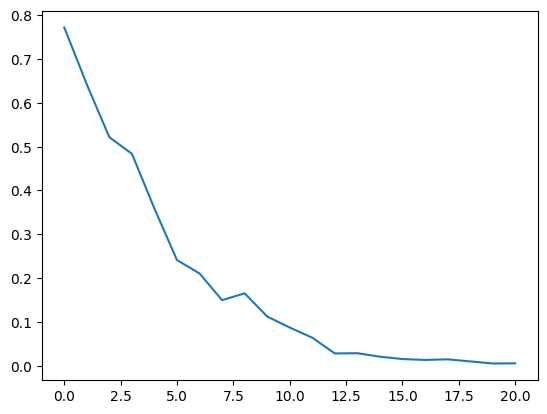

In [ ]:
import matplotlib.pyplot as plt

err = jnp.sum((jnp.stack(means, axis=0) - TRUE_THETA)**2, axis=1)

plt.plot(err)

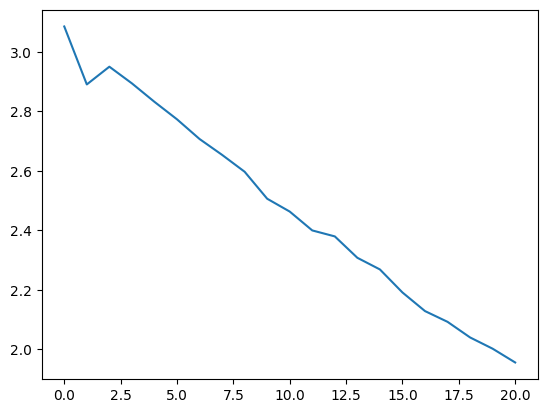

In [11]:
plt.plot(jnp.sum(jnp.stack(stds, axis=0), axis=1))